In [58]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000


In [2]:
train_raw = pd.read_csv('train.csv')
train = train_raw.copy()

In [3]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train_raw['Id']
train.drop(['Id'], axis=1, inplace=True)
train_raw.drop(['Id'], axis=1, inplace=True)

In [4]:
train.shape, train_raw.shape

((1460, 80), (1460, 80))

In [5]:
train_ID.shape

(1460,)

# Feature fix


In [6]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



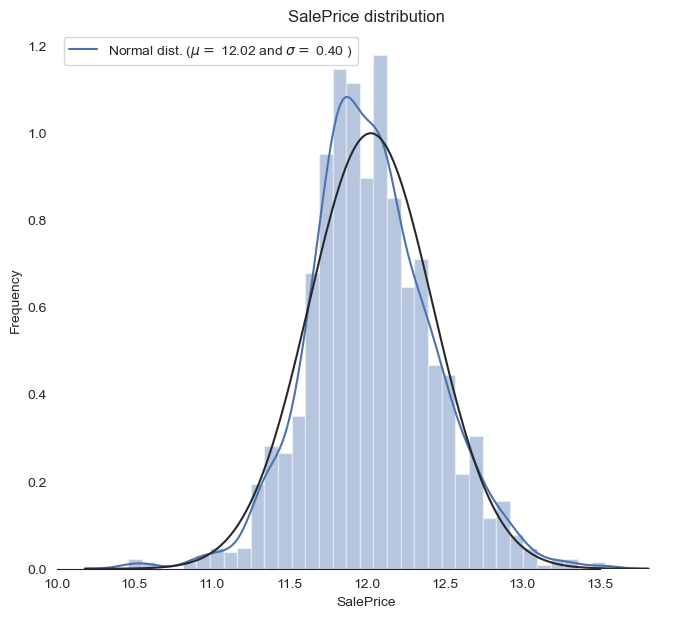

In [7]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

In [8]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [9]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)

In [10]:
train_raw_features = train_raw.drop(['SalePrice'], axis=1)

In [11]:
train_features.shape, train_raw_features.shape

((1458, 79), (1460, 79))

# FILL MISSING VALUES

In [12]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(train_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.59),
 ('MiscFeature', 96.3),
 ('Alley', 93.76),
 ('Fence', 80.73),
 ('FireplaceQu', 47.33),
 ('LotFrontage', 17.76),
 ('GarageType', 5.56),
 ('GarageYrBlt', 5.56),
 ('GarageFinish', 5.56),
 ('GarageQual', 5.56)]

In [13]:
missing = percent_missing(train_raw_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('PoolQC', 99.52),
 ('MiscFeature', 96.3),
 ('Alley', 93.77),
 ('Fence', 80.75),
 ('FireplaceQu', 47.26),
 ('LotFrontage', 17.74),
 ('GarageType', 5.55),
 ('GarageYrBlt', 5.55),
 ('GarageFinish', 5.55),
 ('GarageQual', 5.55)]

In [14]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
train_raw_features['MSSubClass'] = train_raw_features['MSSubClass'].apply(str)
train_raw_features['YrSold'] = train_raw_features['YrSold'].astype(str)
train_raw_features['MoSold'] = train_raw_features['MoSold'].astype(str)

In [15]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
train_features['MSSubClass'] = train_features['MSSubClass'].apply(str)
train_features['YrSold'] = train_features['YrSold'].astype(str)
train_features['MoSold'] = train_features['MoSold'].astype(str)

In [16]:
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

train_features = handle_missing(train_features)
train_raw_features = handle_missing(train_raw_features)

In [17]:
# Let's make sure we handled all the missing values
missing = percent_missing(train_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

In [18]:
# Let's make sure we handled all the missing values
missing = percent_missing(train_raw_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

# SKEWED FEATURES FIX

In [19]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train_features.columns:
    if train_features[i].dtype in numeric_dtypes:
        numeric.append(i)

In [20]:
# Find skewed numerical features
skew_features = train_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
dtype: float64

In [21]:
# Normalize skewed features
for i in skew_index:
    train_features[i] = boxcox1p(train_features[i], boxcox_normmax(train_features[i] + 1))

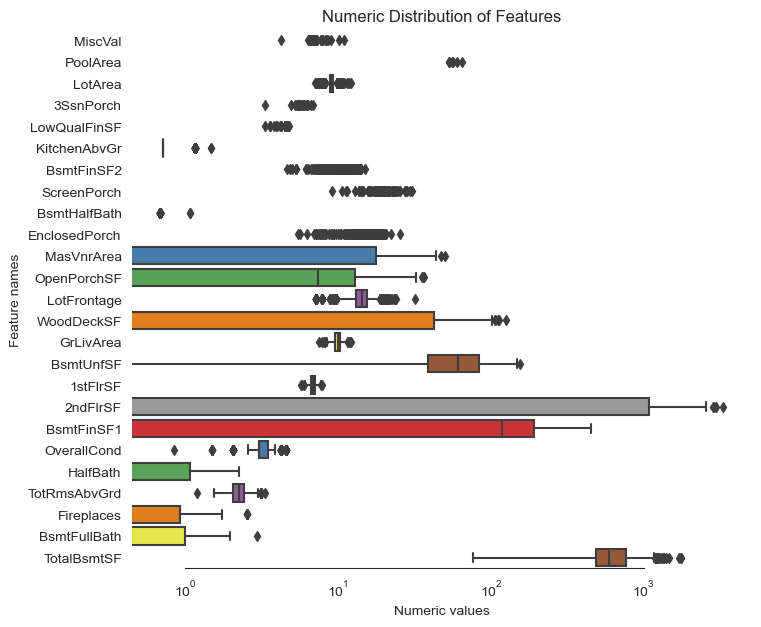

In [22]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=train_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

# COMPLEX FEATURES

In [23]:
train_features['BsmtFinType1_Unf'] = 1*(train_features['BsmtFinType1'] == 'Unf')
train_features['HasWoodDeck'] = (train_features['WoodDeckSF'] == 0) * 1
train_features['HasOpenPorch'] = (train_features['OpenPorchSF'] == 0) * 1
train_features['HasEnclosedPorch'] = (train_features['EnclosedPorch'] == 0) * 1
train_features['Has3SsnPorch'] = (train_features['3SsnPorch'] == 0) * 1
train_features['HasScreenPorch'] = (train_features['ScreenPorch'] == 0) * 1
train_features['YearsSinceRemodel'] = train_features['YrSold'].astype(int) - train_features['YearRemodAdd'].astype(int)
train_features['Total_Home_Quality'] = train_features['OverallQual'] + train_features['OverallCond']
train_features = train_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
train_features['TotalSF'] = train_features['TotalBsmtSF'] + train_features['1stFlrSF'] + train_features['2ndFlrSF']
train_features['YrBltAndRemod'] = train_features['YearBuilt'] + train_features['YearRemodAdd']

train_features['Total_sqr_footage'] = (train_features['BsmtFinSF1'] + train_features['BsmtFinSF2'] +
                                 train_features['1stFlrSF'] + train_features['2ndFlrSF'])
train_features['Total_Bathrooms'] = (train_features['FullBath'] + (0.5 * train_features['HalfBath']) +
                               train_features['BsmtFullBath'] + (0.5 * train_features['BsmtHalfBath']))
train_features['Total_porch_sf'] = (train_features['OpenPorchSF'] + train_features['3SsnPorch'] +
                              train_features['EnclosedPorch'] + train_features['ScreenPorch'] +
                              train_features['WoodDeckSF'])
train_features['TotalBsmtSF'] = train_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
train_features['2ndFlrSF'] = train_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
train_features['GarageArea'] = train_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
train_features['GarageCars'] = train_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
train_features['LotFrontage'] = train_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
train_features['MasVnrArea'] = train_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
train_features['BsmtFinSF1'] = train_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

train_features['haspool'] = train_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_features['has2ndfloor'] = train_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train_features['hasgarage'] = train_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_features['hasbsmt'] = train_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_features['hasfireplace'] = train_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# FEATURES TRANSFORMATION

In [24]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

train_features = logs(train_features, log_features)

In [25]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']
train_features = squares(train_features, squared_features)

# Encode categorical features

In [26]:
train_features_label_enc = train_features.copy()

In [27]:
le_preprocess = LabelEncoder()
for col in train_features_label_enc.columns.values:
    if train_features_label_enc[col].dtypes == 'object':
        train_features_label_enc[col] = le_preprocess.fit_transform(train_features_label_enc[col].astype(str))

In [28]:
#get dummies
train_features = pd.get_dummies(train_features).reset_index(drop=True)
print(train_features.shape)

(1458, 378)


In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in train_raw_features.columns.values:
    if train_raw_features[col].dtypes == 'object':
        train_raw_features[col] = le.fit_transform(train_raw_features[col].astype(str))

In [30]:
# Remove any duplicated column names
train_features = train_features.loc[:,~train_features.columns.duplicated()]

In [31]:
train_features.shape, train_raw_features.shape, train_features_label_enc.shape

((1458, 377), (1460, 79), (1458, 132))

# Evaluate

In [32]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [33]:
train_features.shape, train_raw_features.shape, train_features_label_enc.shape

((1458, 377), (1460, 79), (1458, 132))

In [34]:
train_raw_labels = train_raw['SalePrice'].reset_index(drop=True)

In [35]:
train_labels.shape, train_raw_labels.shape

((1458,), (1460,))

In [56]:
def split_evaluate(dfraw, labelraw, dfprocessed, labelprocessed, n):
    output = pd.DataFrame(columns=['Seed', 'Model_raw_r2', 'Model_processed_r2', 'Model_raw_MSE', 'Model_processed_MSE', 'Model_raw_RMSE', 'Model_processed_RMSE', 'Model_raw_MAE', 'Model_processed_MAE'])
    for i in range(0,n):
        seed = i
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(dfraw, labelraw, test_size=0.2, random_state=seed)
        X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(dfprocessed, labelprocessed, test_size=0.2, random_state=seed)
        model_raw = LinearRegression()
        model_processed = LinearRegression()  
        model_raw.fit(X_train_raw, y_train_raw)
        model_processed.fit(X_train_processed, y_train_processed)
        y_pred_raw = model_raw.predict(X_test_raw)
        y_pred_processed = model_processed.predict(X_test_processed)
        raw_r2 = r2_score(y_test_raw, y_pred_raw)
        processed_r2 = r2_score(y_test_processed, y_pred_processed)
        raw_MSE = mean_squared_error(y_test_raw, y_pred_raw)
        processed_MSE = mean_squared_error(y_test_processed, y_pred_processed)
        raw_RMSE = np.sqrt(mean_squared_error(y_test_raw, y_pred_raw))
        processed_RMSE = np.sqrt(mean_squared_error(y_test_processed, y_pred_processed))
        raw_MAE = mean_absolute_error(y_test_raw, y_pred_raw)
        processed_MAE = mean_absolute_error(y_test_processed, y_pred_processed)
        output = output.append({'Seed': i, 'Model_raw_r2': raw_r2, 'Model_processed_r2': processed_r2, 'Model_raw_MSE': raw_MSE, 'Model_processed_MSE': processed_MSE, 'Model_raw_RMSE': raw_RMSE, 'Model_processed_RMSE': processed_RMSE, 'Model_raw_MAE': raw_MAE, 'Model_processed_MAE': processed_MAE}, ignore_index=True)
    return output

In [60]:
LR_CV = split_evaluate(train_raw_features, train_raw_labels, train_features, train_labels, 20)
pd.DataFrame(LR_CV)

,Seed,Model_raw_r2,Model_processed_r2,Model_raw_MSE,Model_processed_MSE,Model_raw_RMSE,Model_processed_RMSE,Model_raw_MAE,Model_processed_MAE
0,0.0,0.557503,0.917181,3.055821e+09,0.014036,55279.478511,0.118472,24853.411234,0.087071
1,1.0,0.819454,0.023687,1.287643e+09,0.155785,35883.749511,0.394696,19894.545681,0.123998
2,2.0,0.765616,0.832210,1.552154e+09,0.026870,39397.386248,0.163920,21054.178747,0.094674
3,3.0,0.496773,0.886117,2.484822e+09,0.016120,49847.986512,0.126965,21344.857347,0.088610
4,4.0,0.814816,0.285295,1.028145e+09,0.117908,32064.702786,0.343377,20402.813172,0.107308
5,5.0,0.789928,0.858818,1.363366e+09,0.020979,36923.792472,0.144842,21842.236108,0.090207
6,6.0,0.817173,0.918579,1.392768e+09,0.014247,37319.809445,0.119360,21073.277774,0.086022
7,7.0,0.865372,0.871947,9.736589e+08,0.022374,31203.507818,0.149581,20185.267892,0.093085
8,8.0,0.744890,0.903559,1.342454e+09,0.012766,36639.519656,0.112987,21484.161636,0.078597
9,9.0,0.839369,0.663836,1.114760e+09,0.053550,33388.022827,0.231408,20550.244109,0.093725


Bảng kết quả (model_raw = one hot encoder và model_processed = label encoder)

In [91]:
LR_CV_encode = split_evaluate(train_features, train_labels, train_features_label_enc, train_labels, 20)
pd.DataFrame(LR_CV_encode)

,Seed,Model_raw_r2,Model_processed_r2,Model_raw_MSE,Model_processed_MSE,Model_raw_RMSE,Model_processed_RMSE,Model_raw_MAE,Model_processed_MAE
0,0.0,0.917181,0.908712,0.014036,0.015471,0.118472,0.124382,0.087071,0.084788
1,1.0,0.023687,0.883122,0.155785,0.018650,0.394696,0.136563,0.123998,0.093506
2,2.0,0.832210,0.794691,0.026870,0.032878,0.163920,0.181323,0.094674,0.094051
3,3.0,0.886117,0.818986,0.016120,0.025622,0.126965,0.160070,0.088610,0.092421
4,4.0,0.285295,0.917120,0.117908,0.013673,0.343377,0.116931,0.107308,0.081032
5,5.0,0.858818,0.868865,0.020979,0.019486,0.144842,0.139593,0.090207,0.090561
6,6.0,0.918579,0.908414,0.014247,0.016025,0.119360,0.126591,0.086022,0.089476
7,7.0,0.871947,0.886082,0.022374,0.019905,0.149581,0.141084,0.093085,0.095578
8,8.0,0.903559,0.879096,0.012766,0.016004,0.112987,0.126508,0.078597,0.083292
9,9.0,0.663836,0.902204,0.053550,0.015579,0.231408,0.124814,0.093725,0.082752


kiểm định MSE (raw và processed data) 

In [64]:
with_features = LR_CV['Model_processed_MSE'].tolist()
without_features = LR_CV['Model_raw_MSE'].tolist()
compare = [without_features[i] - with_features[i] for i in range(len(with_features))]

In [65]:
import numpy as np
import math

dbar = np.mean(compare)
s = np.std(compare)
n = len(compare)
df = n - 1
print('dbar = ', dbar)
print('s = ', s)

dbar =  1571898700.428043
s =  814543076.4460812


Đặt μ là mean của toàn bộ mse của trước trừ sau tiền xử lý </br>
H0: μ=0 (hai phương pháp cho kết quả như nhau) </br>
H1: μ>0 (tiền xử lý tốt hơn phương pháp cũ) </br>

In [66]:
df 

19

In [67]:
mu = 0
t_value = (dbar - mu)/(s/n**(1/2))
print(t_value)

8.630292122146223


In [68]:
from scipy.stats import t

# Tính giá trị p cho giá trị t
p_value = t.sf(t_value, df, loc=1)
print(p_value)

1.6798667550224664e-07


In [69]:
alpha = 0.05

if p_value < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn


qua thước đó mse thì có sự khác biệt lớn (sau tiền xử lý tốt hơn rất nhiều) </br>

Kiểm định r2 score (raw và processed data) </br>

In [71]:
#tương tự đối với r2
with_features_r2 = LR_CV['Model_processed_r2'].tolist()
without_features_r2 = LR_CV['Model_raw_r2'].tolist()
compare_r2 = [with_features_r2[i] - without_features_r2[i] for i in range(len(with_features_r2))]
dbar_r2 = np.mean(compare_r2)
s_r2 = np.std(compare_r2)
n_r2 = len(compare_r2)
df_r2 = n_r2 - 1
print('dbar = ', dbar_r2)
print('s = ', s_r2)

dbar =  -0.019968320847149862
s =  0.3443026667232342


In [72]:
mu_r2 = 0
t_value_r2 = (dbar_r2 - mu_r2)/(s_r2/n_r2**(1/2))
print(t_value_r2)

-0.25936785930644773


In [73]:
p_value_r2 = t.sf(t_value_r2, df_r2, loc=1)
print(p_value_r2)

0.8884252563621742


In [92]:
alpha = 0.05

if p_value_r2 < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau


=> r2 của cả 2 phương pháp là như nhau

Kiểm định rmse (raw và processed data) </br>


In [106]:
#tương tự đối với RMSE
with_features_RMSE = LR_CV['Model_processed_RMSE'].tolist()
without_features_RMSE = LR_CV['Model_raw_RMSE'].tolist()
compare_RMSE = [without_features_RMSE[i] - with_features_RMSE[i] for i in range(len(with_features_RMSE))]
dbar_RMSE = np.mean(compare_RMSE)
s_RMSE = np.std(compare_RMSE)
n_RMSE = len(compare_RMSE)
df_RMSE = n_RMSE - 1
print('dbar = ', dbar_RMSE)
print('s = ', s_RMSE)

dbar =  38554.6144772288
s =  9242.608454417792


In [107]:
mu_RMSE = 0
t_value_RMSE = (dbar_RMSE - mu_RMSE)/(s_RMSE/n_RMSE**(1/2))
print(t_value_RMSE)

18.655066747131112


In [108]:
p_value_RMSE = t.sf(t_value_RMSE, df_RMSE, loc=1)
print(p_value_RMSE)

1.5168224327676426e-13


In [110]:
alpha = 0.05

if p_value_RMSE < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn


kiểm định mae (raw và processed data) </br>

In [111]:
#tương tự đối với MAE
with_features_MAE = LR_CV['Model_processed_MAE'].tolist()
without_features_MAE = LR_CV['Model_raw_MAE'].tolist()
compare_MAE = [without_features_MAE[i] - with_features_MAE[i] for i in range(len(with_features_MAE))]
dbar_MAE = np.mean(compare_MAE)
s_MAE = np.std(compare_MAE)
n_MAE = len(compare_MAE)
df_MAE = n_MAE - 1
print('dbar = ', dbar_MAE)
print('s = ', s_MAE)

dbar =  21141.31208091798
s =  1424.1814755120247


In [112]:
mu_MAE = 0
t_value_MAE = (dbar_MAE - mu_MAE)/(s_MAE/n_MAE**(1/2))
print(t_value_MAE)

66.38677971776639


In [113]:
p_value_MAE = t.sf(t_value_MAE, df_MAE, loc=1)
print(p_value_MAE)

3.910643839205265e-24


In [114]:
alpha = 0.05

if p_value_MAE < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn


=> Phương pháp tiền xử lý tốt hơn nhiều

kiểm định mse (one hot encoder và label encoder) </br>

In [93]:
#tương tự đối với mse encode
with_features_encode = LR_CV_encode['Model_processed_MSE'].tolist()
without_features_encode = LR_CV_encode['Model_raw_MSE'].tolist()
compare_encode = [without_features_encode[i] - with_features_encode[i] for i in range(len(with_features_encode))]
dbar_encode = np.mean(compare_encode)
s_encode = np.std(compare_encode)   
n_encode = len(compare_encode)
df_encode = n_encode - 1
print('dbar = ', dbar_encode)   
print('s = ', s_encode)

dbar =  0.02487766566876732
s =  0.05830695745851957


In [94]:
mu_encode = 0
t_value_encode = (dbar_encode - mu_encode)/(s_encode/n_encode**(1/2))
print(t_value_encode)

1.9081136791077182


In [95]:
p_value_encode = t.sf(t_value_encode, df_encode, loc=1)
print(p_value_encode)

0.1875965506087755


In [96]:
alpha = 0.05

if p_value_encode < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau


kiểm định r2 score(one hot encoder và label encoder) </br>

In [102]:
#tương tự đối với r2 encode
with_features_r2_encode = LR_CV_encode['Model_processed_r2'].tolist()
without_features_r2_encode = LR_CV_encode['Model_raw_r2'].tolist()
compare_r2_encode = [with_features_r2_encode[i] - without_features_r2_encode[i] for i in range(len(with_features_r2_encode))]
dbar_r2_encode = np.mean(compare_r2_encode)
s_r2_encode = np.std(compare_r2_encode)
n_r2_encode = len(compare_r2_encode)
df_r2_encode = n_r2_encode - 1
print('dbar = ', dbar_r2_encode)
print('s = ', s_r2_encode)

dbar =  0.15016317446525673
s =  0.35142583835702906


In [103]:
mu_r2_encode = 0
t_value_r2_encode = (dbar_r2_encode - mu_r2_encode)/(s_r2_encode/n_r2_encode**(1/2))
print(t_value_r2_encode)

1.9109298701044624


In [104]:
p_value_r2_encode = t.sf(t_value_r2_encode, df_r2_encode, loc=1)
print(p_value_r2_encode)

0.18687248822895425


In [105]:
alpha = 0.05

if p_value_r2_encode < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau


kiểm định rmse (one hot encoder và label encoder) </br>
    

In [123]:
#tương tự đối với RMSE encode
with_features_RMSE_encode = LR_CV_encode['Model_processed_RMSE'].tolist()
without_features_RMSE_encode = LR_CV_encode['Model_raw_RMSE'].tolist()
compare_RMSE_encode = [without_features_RMSE_encode[i] - with_features_RMSE_encode[i] for i in range(len(with_features_RMSE_encode))]
dbar_RMSE_encode = np.mean(compare_RMSE_encode)
s_RMSE_encode = np.std(compare_RMSE_encode)
n_RMSE_encode = len(compare_RMSE_encode)
df_RMSE_encode = n_RMSE_encode - 1
print('dbar = ', dbar_RMSE_encode)
print('s = ', s_RMSE_encode)    
    

dbar =  0.04800307299273199
s =  0.10467812958393435


In [124]:
mu_RMSE_encode = 0
t_value_RMSE_encode = (dbar_RMSE_encode - mu_RMSE_encode)/(s_RMSE_encode/n_RMSE_encode**(1/2))
print(t_value_RMSE_encode)

2.0508225503698125


In [125]:
p_value_RMSE_encode = t.sf(t_value_RMSE_encode, df_RMSE_encode, loc=1)
print(p_value_RMSE_encode)
    

0.15326127031775993


In [127]:
alpha = 0.05

if p_value_RMSE_encode < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau


In [128]:
#tương tự đối với MAE encode
with_features_MAE_encode = LR_CV_encode['Model_processed_MAE'].tolist()
without_features_MAE_encode = LR_CV_encode['Model_raw_MAE'].tolist()
compare_MAE_encode = [without_features_MAE_encode[i] - with_features_MAE_encode[i] for i in range(len(with_features_MAE_encode))]
dbar_MAE_encode = np.mean(compare_MAE_encode)
s_MAE_encode = np.std(compare_MAE_encode)
n_MAE_encode = len(compare_MAE_encode)
df_MAE_encode = n_MAE_encode - 1
print('dbar = ', dbar_MAE_encode)
print('s = ', s_MAE_encode)

dbar =  0.004504080677009451
s =  0.012337041679858976


In [129]:
mu_MAE_encode = 0
t_value_MAE_encode = (dbar_MAE_encode - mu_MAE_encode)/(s_MAE_encode/n_MAE_encode**(1/2))
print(t_value_MAE_encode)
    

1.6327140381439535


In [131]:
p_value_MAE_encode = t.sf(t_value_MAE_encode, df_MAE_encode, loc=1)
print(p_value_MAE_encode)

0.26723089769487274


In [132]:
alpha = 0.05

if p_value_MAE_encode < alpha:
    print("Bác bỏ H0, chấp nhận H1, phương pháp tiền xử lý thực sự cho kết quả tốt hơn")
else:
    print('Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau')

Không thể bác bỏ H0, hai phương pháp cho kết quả như nhau


=> khi chọn kiểu encode đối với thuộc tính categorized thì label encoding hay one hot encoding đều cho ra kết quả là như nhau

# (đồ thị biểu thị sự thay đổi của MSE theo seed) (raw và processed data)

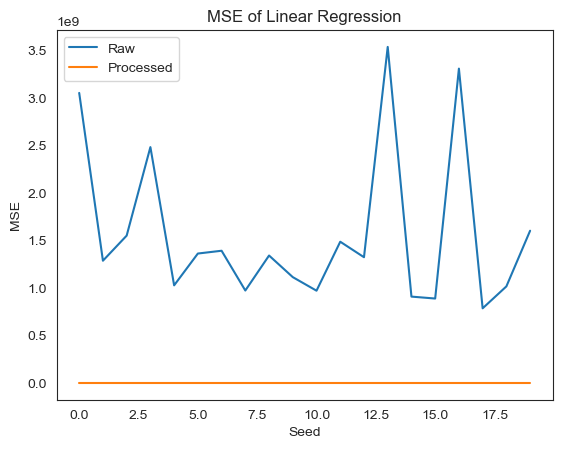

In [97]:
#plot for MSE 
import matplotlib.pyplot as plt
plt.plot(LR_CV['Seed'], LR_CV['Model_raw_MSE'], label='Raw')
plt.plot(LR_CV['Seed'], LR_CV['Model_processed_MSE'], label='Processed')
plt.xlabel('Seed')
plt.ylabel('MSE')
plt.title('MSE of Linear Regression')

plt.legend()

# (đồ thị biểu thị sự thay đổi của r2 theo seed)

Text(0.5, 1.0, 'r2 of Linear Regression')

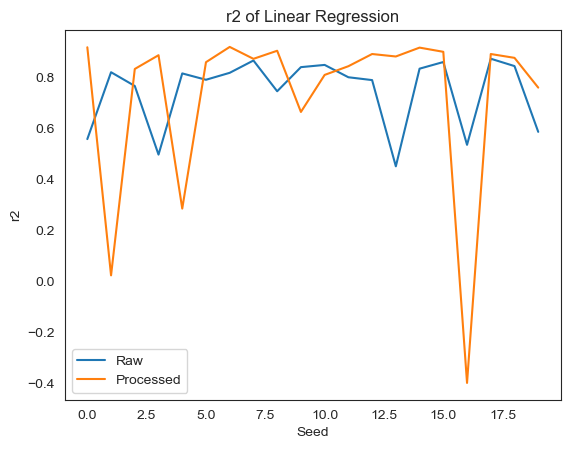

In [101]:
#plot for r2 
plt.plot(LR_CV['Seed'], LR_CV['Model_raw_r2'], label='Raw')
plt.plot(LR_CV['Seed'], LR_CV['Model_processed_r2'], label='Processed')
#show label
plt.legend()
plt.xlabel('Seed')
plt.ylabel('r2')
plt.title('r2 of Linear Regression')

đồ thị hiệu của process và raw (r2)

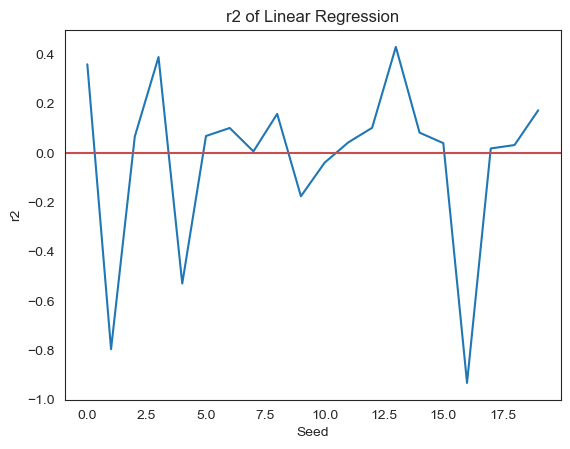

In [99]:
#plot to compare r2 
plt.plot(LR_CV['Seed'], compare_r2)
plt.xlabel('Seed')
plt.ylabel('r2')
plt.title('r2 of Linear Regression')
#make a line at y = 0
plt.axhline(y=0, color='r', linestyle='-')

do 2 phương pháp khác nhau nhiều nên chỉ có chừng này plot thui

# Đồ thị biểu thị sự thay đổi của MSE theo seed (one hot encoder và label encoder)

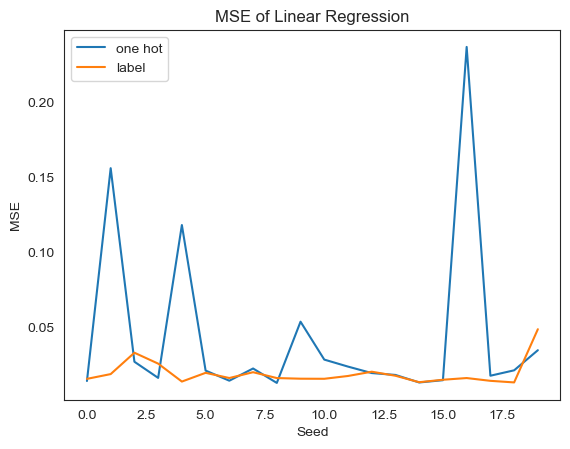

In [119]:
#plot of one hot encode and label encode (mse)
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_raw_MSE'], label='one hot')
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_processed_MSE'], label='label')
plt.xlabel('Seed')
plt.ylabel('MSE')   
plt.title('MSE of Linear Regression')
plt.legend()

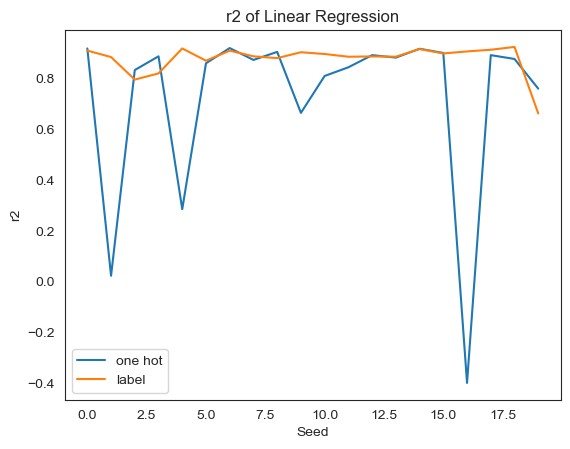

In [120]:
#plot of one hot encode and label encode (r2)
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_raw_r2'], label='one hot')
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_processed_r2'], label='label')
plt.xlabel('Seed')
plt.ylabel('r2')
plt.title('r2 of Linear Regression')
plt.legend()

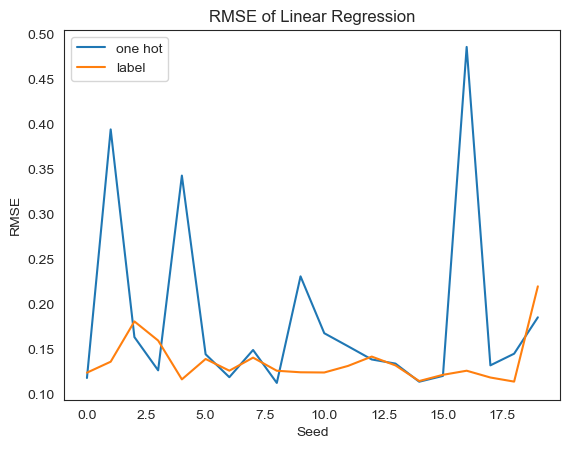

In [121]:
#plot of one hot encode and label encode (rmse)
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_raw_RMSE'], label='one hot')
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_processed_RMSE'], label='label')
plt.xlabel('Seed')
plt.ylabel('RMSE')
plt.title('RMSE of Linear Regression')
plt.legend()

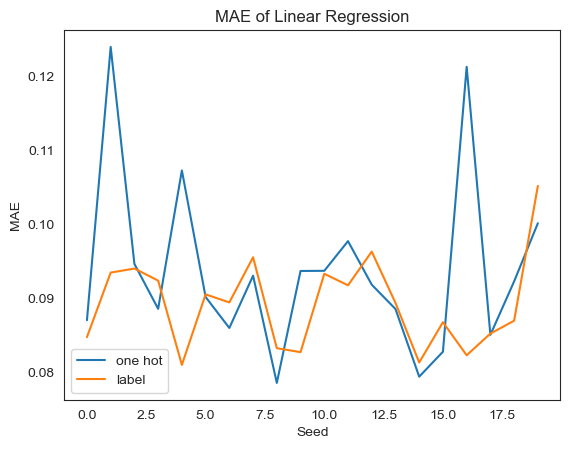

In [122]:
#plot of one hot encode and label encode (mae)
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_raw_MAE'], label='one hot')
plt.plot(LR_CV_encode['Seed'], LR_CV_encode['Model_processed_MAE'], label='label')
plt.xlabel('Seed')
plt.ylabel('MAE')
plt.title('MAE of Linear Regression')
plt.legend()
